In [1]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *

from matplotlib.path import Path
%matplotlib inline

import numpy as np

from learning_utilities import *

Setting environment for Gordon


No vtk
Cannot import mxnet.


In [2]:
from sklearn.externals import joblib

In [3]:
def convert_to_surround_name(name_u, suffix):
    return name_u + '_surround_' + suffix

In [4]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', 'SNC', 'SNR', '3N', '4N',
                    'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']
structures = paired_structures + singular_structures

In [5]:
# structures = ['7N', '12N']
# labels_to_sample = structures + map(convert_to_surround_name, structures)
labels_to_sample = structures + [convert_to_surround_name(l, surr_l) for l in structures for surr_l in structures + ['noclass'] if surr_l not in l]

In [6]:
# Extract training features - random subset

training_addresses = defaultdict(list)

labels = set([])

for stack in ['MD589', 'MD585', 'MD594']:
    annotation_grid_indices_fn = '/home/yuncong/csd395/CSHL_labelings_v3/%(stack)s/%(stack)s_annotation_grid_indices.h5' % dict(stack=stack)
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    
    labels_this_stack = set(label_gridIndices.index) & set(labels_to_sample)
    labels = labels | labels_this_stack
    
    training_addresses_sec_idx = sample_locations(label_gridIndices, labels_this_stack, num_samples_per_landmark=1000)
    
    for name_u, addresses in training_addresses_sec_idx.iteritems():
        training_addresses[name_u] += [(stack, ) + addr for addr in addresses]
        
training_addresses.default_factory = None
        
# sampled_addresses = {name_u: np.array(addresses) for name_u, addresses in sampled_addresses.iteritems()}

Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.


In [65]:
# See if we can use location on image frame as feature

# def addresses_to_locations(addresses):
    
#     key_func = lambda (i, (st, se, idx)): st
    
#     locations = []
    
#     for stack, group in groupby(sorted(enumerate(addresses), key=key_func), key=key_func):
#         sample_locations = grid_parameters_to_sample_locations(get_default_gridspec(stack))
#         for i, (st, se, idx) in group:
#             locations.append((i, sample_locations[idx]))
    
#     return [loc for i, loc in sorted(locations)]

In [66]:
# locations = np.array(addresses_to_locations(training_addresses['10N']))

# plt.scatter(locations[:,0], locations[:,1]);
# plt.xlim([0, 15000]);
# plt.ylim([0, 12000]);

In [ ]:
training_features = apply_function_to_dict(addresses_to_features, training_addresses)

In [41]:
training_features = {name: np.array([f for f in feats if f is not None]) 
                     for name, feats in training_features.iteritems()}

In [42]:
for name in sorted(training_features.iterkeys()):
    print name, len(training_features[name])

10N 2609
10N_surround_12N 3000
10N_surround_AP 367
10N_surround_noclass 3000
12N 3000
12N_surround_10N 2460
12N_surround_AP 161
12N_surround_noclass 3000
3N 3000
3N_surround_4N 246
3N_surround_noclass 3000
4N 474
4N_surround_3N 720
4N_surround_noclass 3000
5N 3000
5N_surround_7n 25
5N_surround_noclass 3000
6N 862
6N_surround_7n 353
6N_surround_noclass 3000
7N 3000
7N_surround_Amb 38
7N_surround_noclass 3000
7n 3000
7n_surround_5N 19
7n_surround_6N 311
7n_surround_noclass 3000
AP 3000
AP_surround_10N 140
AP_surround_12N 204
AP_surround_noclass 3000
Amb 1570
Amb_surround_7N 59
Amb_surround_LRt 160
Amb_surround_noclass 3000
DC 2999
DC_surround_VCA 3000
DC_surround_VCP 3000
DC_surround_noclass 3000
IC 3000
IC_surround_SC 3000
IC_surround_noclass 3000
LC 3000
LC_surround_noclass 3000
LRt 2995
LRt_surround_Amb 109
LRt_surround_Sp5C 71
LRt_surround_noclass 3000
PBG 2717
PBG_surround_SNR 350
PBG_surround_VLL 105
PBG_surround_noclass 3000
Pn 3000
Pn_surround_RtTg 3000
Pn_surround_Tz 8
Pn_surrou

In [ ]:
# Save training features

train_feat_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR, 'training_features/'))

for name_u, feats in training_features.iteritems():
    bp.pack_ndarray_file(feats, os.path.join(train_feat_dir, name_u + '_trainSampleScheme_%(scheme)d.bp' % dict(scheme=train_sample_scheme)))

In [ ]:
# Load training features

training_features = {name_u: bp.unpack_ndarray_file(os.path.join(SVM_ROOTDIR, 'training_features', \
                                 name_u + '_trainSampleScheme_1.bp'))
                     for name_u in labels}

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
from xgboost.sklearn import XGBClassifier

In [144]:
# negatives are surrounding patches that are not of other positive classes
# LogisticRegression(penalty='l2')
train_sample_scheme = 1

# negatives are surrounding patches that include other positive classes
# LogisticRegression(penalty='l1')
# train_sample_scheme = 2

# negatives are surrounding patches that are not of other positive classes
# SVC(kernel='linear')
# train_sample_scheme = 3

# negatives are surrounding patches that are not of other positive classes
# LinearSVC(kernel='linear') + CalibratedClassifierCV
# train_sample_scheme = 4

# negatives are surrounding patches that are not of other positive classes
# XGBClassifier
# train_sample_scheme = 5

# negatives are surrounding patches that are not of other positive classes
# sklearn.ensemble.GradientBoostingClassifier, max_depth=3, n_estimators=200
# train_sample_scheme = 6

# negatives are surrounding patches that are not of other positive classes
# sklearn.ensemble.GradientBoostingClassifier, max_depth=5, n_estimators=100
train_sample_scheme = 7

In [145]:
# train svm classifiers

svm_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR, 'classifiers'))
# svm_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR + '/trainSampleScheme_%(scheme)d' % {'scheme':train_sample_scheme}))

for label in structures:
            
    print label

    t = time.time()

    features_pos = training_features[label]
    
    if train_sample_scheme in [1, 3, 4, 5, 6, 7]:
        features_neg = training_features[convert_to_surround_name(label, 'noclass')]
    elif train_sample_scheme == 2:
        features_neg = np.vstack([training_features[convert_to_surround_name(label, 'noclass')]] + \
                                  [training_features[convert_to_surround_name(label, surr_l)] 
                                  for surr_l in structures if convert_to_surround_name(label, surr_l) in labels])
    else:
        sys.stderr.write('training scheme is not recognized.\n')
   
    train_data0 = np.r_[features_pos, features_neg]
    train_labels0 = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]

    train_data = train_data0
    train_labels = train_labels0
    
#     svc = SVC(C=1.0, kernel='rbf', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
#           probability=True, tol=0.001, cache_size=1000, class_weight=None, verbose=False, 
#           max_iter=-1, decision_function_shape=None, random_state=None)

    if train_sample_scheme == 1:
        # L2 penalty - train: 0.88, test acc: 0.84
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

    elif train_sample_scheme == 2:
        # L1 penalty - test acc: 0.818
        clf = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

            
    elif train_sample_scheme == 3:
        # Slow - train acc: 0.69, test acc: 0.68
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})


    elif train_sample_scheme == 4:
        # train 0.75, test 0.74
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
#         clf.fit(train_data, train_labels)
#         joblib.dump(clf, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

        
    elif train_sample_scheme == 5:
        # train 
        
        # http://xgboost.readthedocs.io/en/latest/python/python_api.html
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
#         clf.fit(train_data, train_labels)
#         joblib.dump(svc, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

    elif train_sample_scheme == 6:
        # acc: 0.96/0.85
        
        # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    elif train_sample_scheme == 7:
        # acc: 0.98/0.87
        
        # http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('training scheme is not recognized.\n')
 
    sys.stderr.write('train classifier: %.2f seconds\n' % (time.time() - t))
    
    clf.fit(train_data, train_labels)
    joblib.dump(clf, svm_dir + '/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})
        
#     del features_pos, features_neg, train_data, train_labels, svc

5N


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0807            2.28m
         2           0.9020            2.06m
         3           0.7791            1.99m
         4           0.6963            1.94m
         5           0.6355            1.90m
         6           0.5874            1.86m
         7           0.5450            1.84m
         8           0.5126            1.81m
         9           0.4865            1.78m
        10           0.4661            1.75m
        20           0.3148            1.51m
        30           0.2289            1.29m
        40           0.1705            1.10m
        50           0.1268           54.50s
        60           0.0964           43.49s
        70           0.0733           32.55s
        80           0.0562           21.67s
        90           0.0431           10.84s
       100           0.0333            0.00s
6N


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           0.7092           59.52s
         2           0.5586           59.84s
         3           0.4587            1.00m
         4           0.3940           59.14s
         5           0.3414           58.78s
         6           0.3035           57.96s
         7           0.2713           57.58s
         8           0.2527           56.32s
         9           0.2312           55.77s
        10           0.2080           55.54s
        20           0.0885           49.72s
        30           0.0421           43.58s
        40           0.0217           37.52s
        50           0.0120           31.19s
        60           0.0073           24.89s
        70           0.0041           18.67s
        80           0.0023           12.48s
        90           0.0013            6.24s
       100           0.0007            0.00s
7N


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0804            1.92m
         2           0.8972            1.90m
         3           0.7740            1.88m
         4           0.6836            1.87m
         5           0.6216            1.85m
         6           0.5701            1.83m
         7           0.5303            1.80m
         8           0.4957            1.78m
         9           0.4687            1.76m
        10           0.4434            1.74m
        20           0.2811            1.53m
        30           0.1976            1.31m
        40           0.1363            1.12m
        50           0.0987           55.71s
        60           0.0714           44.47s
        70           0.0511           33.38s
        80           0.0382           22.19s
        90           0.0287           11.08s
       100           0.0216            0.00s
7n


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           0.9831            1.87m
         2           0.7559            1.83m
         3           0.6098            1.80m
         4           0.5067            1.78m
         5           0.4365            1.76m
         6           0.3793            1.74m
         7           0.3454            1.70m
         8           0.3141            1.68m
         9           0.2885            1.66m
        10           0.2646            1.64m
        20           0.1458            1.45m
        30           0.0860            1.27m
        40           0.0543            1.09m
        50           0.0341           54.20s
        60           0.0223           43.35s
        70           0.0150           32.46s
        80           0.0103           21.60s
        90           0.0072           10.78s
       100           0.0049            0.00s
Amb


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           0.9040            1.31m
         2           0.7029            1.28m
         3           0.5715            1.27m
         4           0.4808            1.25m
         5           0.4096            1.24m
         6           0.3587            1.23m
         7           0.3245            1.21m
         8           0.2913            1.20m
         9           0.2615            1.19m
        10           0.2397            1.17m
        20           0.1128            1.04m
        30           0.0654           54.04s
        40           0.0376           46.18s
        50           0.0224           38.31s
        60           0.0134           30.84s
        70           0.0085           23.13s
        80           0.0050           15.44s
        90           0.0031            7.71s
       100           0.0021            0.00s
LC


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0946            1.89m
         2           0.9279            1.86m
         3           0.8112            1.85m
         4           0.7300            1.83m
         5           0.6740            1.80m
         6           0.6203            1.78m
         7           0.5821            1.76m
         8           0.5495            1.74m
         9           0.5233            1.72m
        10           0.4985            1.70m
        20           0.3324            1.49m
        30           0.2362            1.28m
        40           0.1691            1.09m
        50           0.1240           54.56s
        60           0.0907           43.67s
        70           0.0676           32.69s
        80           0.0521           21.73s
        90           0.0395           10.85s
       100           0.0304            0.00s
LRt


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.1496            1.94m
         2           1.0050            1.91m
         3           0.9013            1.89m
         4           0.8260            1.88m
         5           0.7720            1.86m
         6           0.7263            1.83m
         7           0.6861            1.81m
         8           0.6506            1.79m
         9           0.6182            1.77m
        10           0.5913            1.75m
        20           0.4288            1.50m
        30           0.3298            1.28m
        40           0.2550            1.09m
        50           0.1958           54.28s
        60           0.1487           43.48s
        70           0.1108           32.72s
        80           0.0846           21.84s
        90           0.0658           10.91s
       100           0.0528            0.00s
Pn


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           0.9991            1.84m
         2           0.7724            1.83m
         3           0.6252            1.82m
         4           0.5206            1.80m
         5           0.4464            1.79m
         6           0.3909            1.77m
         7           0.3558            1.73m
         8           0.3209            1.71m
         9           0.2893            1.70m
        10           0.2677            1.68m
        20           0.1464            1.47m
        30           0.0923            1.27m
        40           0.0599            1.09m
        50           0.0380           54.49s
        60           0.0250           43.54s
        70           0.0171           32.60s
        80           0.0121           21.71s
        90           0.0081           10.86s
       100           0.0055            0.00s
Tz


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0133            1.89m
         2           0.8005            1.85m
         3           0.6670            1.80m
         4           0.5744            1.78m
         5           0.5052            1.76m
         6           0.4521            1.75m
         7           0.4148            1.73m
         8           0.3823            1.71m
         9           0.3517            1.70m
        10           0.3275            1.67m
        20           0.1821            1.48m
        30           0.1193            1.28m
        40           0.0764            1.09m
        50           0.0498           54.69s
        60           0.0335           43.71s
        70           0.0231           32.78s
        80           0.0161           21.84s
        90           0.0116           10.89s
       100           0.0084            0.00s
VLL


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0768            1.96m
         2           0.8908            1.93m
         3           0.7739            1.89m
         4           0.6870            1.86m
         5           0.6256            1.83m
         6           0.5809            1.81m
         7           0.5415            1.79m
         8           0.5060            1.77m
         9           0.4788            1.74m
        10           0.4567            1.72m
        20           0.3244            1.48m
        30           0.2385            1.28m
        40           0.1743            1.09m
        50           0.1265           54.57s
        60           0.0908           43.81s
        70           0.0701           32.70s
        80           0.0536           21.77s
        90           0.0396           10.91s
       100           0.0305            0.00s
RMC


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.1454            1.93m
         2           0.9932            1.93m
         3           0.8842            1.90m
         4           0.8052            1.89m
         5           0.7465            1.87m
         6           0.7014            1.84m
         7           0.6600            1.82m
         8           0.6223            1.80m
         9           0.5905            1.78m
        10           0.5680            1.75m
        20           0.3927            1.52m
        30           0.2962            1.31m
        40           0.2229            1.11m
        50           0.1694           55.08s
        60           0.1288           44.02s
        70           0.1016           32.89s
        80           0.0807           21.84s
        90           0.0644           10.88s
       100           0.0514            0.00s
SNC


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.1827            1.95m
         2           1.0571            1.92m
         3           0.9661            1.91m
         4           0.9024            1.88m
         5           0.8526            1.85m
         6           0.8131            1.82m
         7           0.7722            1.79m
         8           0.7369            1.77m
         9           0.7020            1.76m
        10           0.6720            1.74m
        20           0.4736            1.52m
        30           0.3582            1.31m
        40           0.2684            1.11m
        50           0.2050           55.35s
        60           0.1560           44.31s
        70           0.1255           33.07s
        80           0.0992           22.05s
        90           0.0777           11.02s
       100           0.0613            0.00s
SNR


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.2373            1.92m
         2           1.1314            1.90m
         3           1.0486            1.88m
         4           0.9706            1.87m
         5           0.9166            1.86m
         6           0.8698            1.83m
         7           0.8276            1.80m
         8           0.7902            1.78m
         9           0.7528            1.76m
        10           0.7254            1.74m
        20           0.4889            1.54m
        30           0.3624            1.33m
        40           0.2770            1.13m
        50           0.2156           55.91s
        60           0.1648           44.64s
        70           0.1282           33.40s
        80           0.1004           22.21s
        90           0.0791           11.09s
       100           0.0622            0.00s
3N


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0404            1.94m
         2           0.8413            1.91m
         3           0.7069            1.88m
         4           0.6056            1.87m
         5           0.5351            1.84m
         6           0.4783            1.82m
         7           0.4418            1.79m
         8           0.4075            1.77m
         9           0.3801            1.74m
        10           0.3572            1.72m
        20           0.2191            1.50m
        30           0.1337            1.30m
        40           0.0886            1.11m
        50           0.0626           55.27s
        60           0.0444           44.08s
        70           0.0310           33.02s
        80           0.0225           21.97s
        90           0.0164           10.96s
       100           0.0119            0.00s
4N


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           0.4934           52.01s
         2           0.3955           51.59s
         3           0.3269           51.47s
         4           0.2734           51.13s
         5           0.2380           50.46s
         6           0.2060           50.49s
         7           0.1921           48.98s
         8           0.1676           49.09s
         9           0.1504           48.48s
        10           0.1329           48.26s
        20           0.0538           43.01s
        30           0.0273           36.99s
        40           0.0138           31.57s
        50           0.0072           26.25s
        60           0.0038           21.04s
        70           0.0020           15.82s
        80           0.0010           10.53s
        90           0.0006            5.26s
       100           0.0003            0.00s
Sp5I


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0795            1.92m
         2           0.8957            1.91m
         3           0.7720            1.88m
         4           0.6852            1.86m
         5           0.6253            1.82m
         6           0.5756            1.80m
         7           0.5385            1.77m
         8           0.5074            1.75m
         9           0.4758            1.73m
        10           0.4518            1.71m
        20           0.2929            1.49m
        30           0.2060            1.29m
        40           0.1401            1.11m
        50           0.1023           55.03s
        60           0.0770           43.75s
        70           0.0563           32.85s
        80           0.0425           21.83s
        90           0.0318           10.92s
       100           0.0243            0.00s
Sp5O


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.1645            1.96m
         2           1.0320            1.93m
         3           0.9407            1.90m
         4           0.8717            1.89m
         5           0.8175            1.86m
         6           0.7814            1.83m
         7           0.7433            1.81m
         8           0.7111            1.79m
         9           0.6904            1.76m
        10           0.6640            1.74m
        20           0.4784            1.51m
        30           0.3708            1.30m
        40           0.2924            1.10m
        50           0.2306           54.58s
        60           0.1782           43.72s
        70           0.1443           32.60s
        80           0.1173           21.98s
        90           0.0920           11.14s
       100           0.0722            0.00s
Sp5C


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.1679            1.90m
         2           1.0296            1.88m
         3           0.9339            1.86m
         4           0.8655            1.83m
         5           0.8096            1.82m
         6           0.7666            1.79m
         7           0.7350            1.75m
         8           0.7010            1.74m
         9           0.6773            1.71m
        10           0.6509            1.70m
        20           0.4885            1.47m
        30           0.3785            1.27m
        40           0.2990            1.08m
        50           0.2238           54.09s
        60           0.1710           43.31s
        70           0.1318           32.50s
        80           0.1025           21.68s
        90           0.0794           10.86s
       100           0.0600            0.00s
PBG


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0368            1.80m
         2           0.8334            1.77m
         3           0.6991            1.76m
         4           0.6061            1.73m
         5           0.5341            1.72m
         6           0.4809            1.69m
         7           0.4413            1.67m
         8           0.4059            1.65m
         9           0.3786            1.63m
        10           0.3556            1.60m
        20           0.2038            1.41m
        30           0.1303            1.21m
        40           0.0857            1.04m
        50           0.0578           51.69s
        60           0.0396           41.25s
        70           0.0275           30.90s
        80           0.0191           20.59s
        90           0.0135           10.28s
       100           0.0095            0.00s
10N


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.1055            1.81m
         2           0.9353            1.76m
         3           0.8154            1.74m
         4           0.7294            1.73m
         5           0.6601            1.71m
         6           0.6013            1.69m
         7           0.5547            1.68m
         8           0.5161            1.66m
         9           0.4822            1.63m
        10           0.4452            1.62m
        20           0.2630            1.41m
        30           0.1643            1.23m
        40           0.1129            1.04m
        50           0.0769           51.59s
        60           0.0529           41.19s
        70           0.0353           30.95s
        80           0.0242           20.63s
        90           0.0173           10.30s
       100           0.0124            0.00s
VCA


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0029            1.97m
         2           0.7826            1.94m
         3           0.6467            1.90m
         4           0.5490            1.88m
         5           0.4798            1.86m
         6           0.4285            1.84m
         7           0.3860            1.82m
         8           0.3574            1.81m
         9           0.3348            1.79m
        10           0.3150            1.76m
        20           0.1930            1.55m
        30           0.1202            1.36m
        40           0.0801            1.17m
        50           0.0545           58.42s
        60           0.0390           46.69s
        70           0.0273           34.96s
        80           0.0204           23.27s
        90           0.0145           11.63s
       100           0.0105            0.00s
VCP


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.1197            1.98m
         2           0.9623            1.96m
         3           0.8630            1.91m
         4           0.7862            1.90m
         5           0.7262            1.88m
         6           0.6839            1.85m
         7           0.6458            1.83m
         8           0.6138            1.81m
         9           0.5832            1.80m
        10           0.5593            1.78m
        20           0.3884            1.58m
        30           0.2835            1.38m
        40           0.2066            1.19m
        50           0.1565           59.26s
        60           0.1184           47.39s
        70           0.0894           35.60s
        80           0.0672           23.78s
        90           0.0515           11.88s
       100           0.0405            0.00s
DC


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.1010            2.01m
         2           0.9295            1.99m
         3           0.8156            1.97m
         4           0.7376            1.95m
         5           0.6742            1.92m
         6           0.6257            1.89m
         7           0.5920            1.86m
         8           0.5563            1.84m
         9           0.5259            1.82m
        10           0.4993            1.80m
        20           0.3322            1.60m
        30           0.2408            1.38m
        40           0.1738            1.19m
        50           0.1302           59.04s
        60           0.0968           47.18s
        70           0.0704           35.41s
        80           0.0531           23.61s
        90           0.0383           11.83s
       100           0.0284            0.00s
AP


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           0.9745            1.90m
         2           0.7411            1.86m
         3           0.5870            1.84m
         4           0.4823            1.81m
         5           0.4055            1.79m
         6           0.3498            1.78m
         7           0.3034            1.76m
         8           0.2692            1.74m
         9           0.2440            1.71m
        10           0.2201            1.69m
        20           0.1142            1.48m
        30           0.0641            1.29m
        40           0.0418            1.10m
        50           0.0260           54.91s
        60           0.0168           43.87s
        70           0.0110           32.88s
        80           0.0073           21.89s
        90           0.0050           10.93s
       100           0.0034            0.00s
12N


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.0368            1.98m
         2           0.8311            1.99m
         3           0.6939            1.96m
         4           0.6033            1.92m
         5           0.5364            1.89m
         6           0.4807            1.87m
         7           0.4405            1.84m
         8           0.4041            1.82m
         9           0.3748            1.80m
        10           0.3530            1.78m
        20           0.2057            1.56m
        30           0.1306            1.36m
        40           0.0865            1.16m
        50           0.0612           57.48s
        60           0.0417           46.00s
        70           0.0288           34.49s
        80           0.0195           23.06s
        90           0.0133           11.54s
       100           0.0094            0.00s
RtTg


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.1534            2.09m
         2           1.0063            2.07m
         3           0.9104            2.02m
         4           0.8378            1.99m
         5           0.7780            1.97m
         6           0.7324            1.94m
         7           0.6909            1.92m
         8           0.6526            1.90m
         9           0.6166            1.88m
        10           0.5937            1.85m
        20           0.4184            1.60m
        30           0.3209            1.37m
        40           0.2412            1.17m
        50           0.1844           57.98s
        60           0.1448           46.10s
        70           0.1129           34.50s
        80           0.0880           22.99s
        90           0.0679           11.51s
       100           0.0527            0.00s
SC


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.2352            1.92m
         2           1.1408            1.93m
         3           1.0620            1.92m
         4           1.0111            1.89m
         5           0.9656            1.87m
         6           0.9208            1.86m
         7           0.8839            1.84m
         8           0.8505            1.82m
         9           0.8314            1.78m
        10           0.8071            1.76m
        20           0.6095            1.56m
        30           0.4694            1.36m
        40           0.3830            1.15m
        50           0.3129           57.26s
        60           0.2524           45.68s
        70           0.2041           34.19s
        80           0.1700           22.76s
        90           0.1329           11.44s
       100           0.1060            0.00s
IC


train classifier: 0.00 seconds


      Iter       Train Loss   Remaining Time 
         1           1.1026            2.06m
         2           0.9427            2.01m
         3           0.8326            1.99m
         4           0.7473            1.98m
         5           0.6889            1.95m
         6           0.6469            1.90m
         7           0.6106            1.88m
         8           0.5831            1.85m
         9           0.5562            1.83m
        10           0.5347            1.80m
        20           0.3904            1.55m
        30           0.2891            1.34m
        40           0.2291            1.13m
        50           0.1746           56.66s
        60           0.1362           45.16s
        70           0.1089           33.75s
        80           0.0821           22.58s
        90           0.0661           11.25s
       100           0.0509            0.00s


# Load pre-computed svm classifiers

In [146]:
svc_allClasses = {}
for label in structures:
    svc_allClasses[label] = joblib.load(SVM_ROOTDIR + '/classifiers/%(label)s_svm_trainSampleScheme_%(scheme)d.pkl' % {'label': label, 'scheme':train_sample_scheme})

In [34]:
# visualize training patches

In [ ]:
patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP'], 'grid_index')

In [ ]:
display_images_in_grids(patches, 5)

In [ ]:
patches = extract_patches_given_locations_multiple_sections(sampled_addresses['AP_surround'], 'grid_index')

In [ ]:
display_images_in_grids(patches, 5, titles=sampled_addresses['AP_surround'])

In [ ]:
# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)

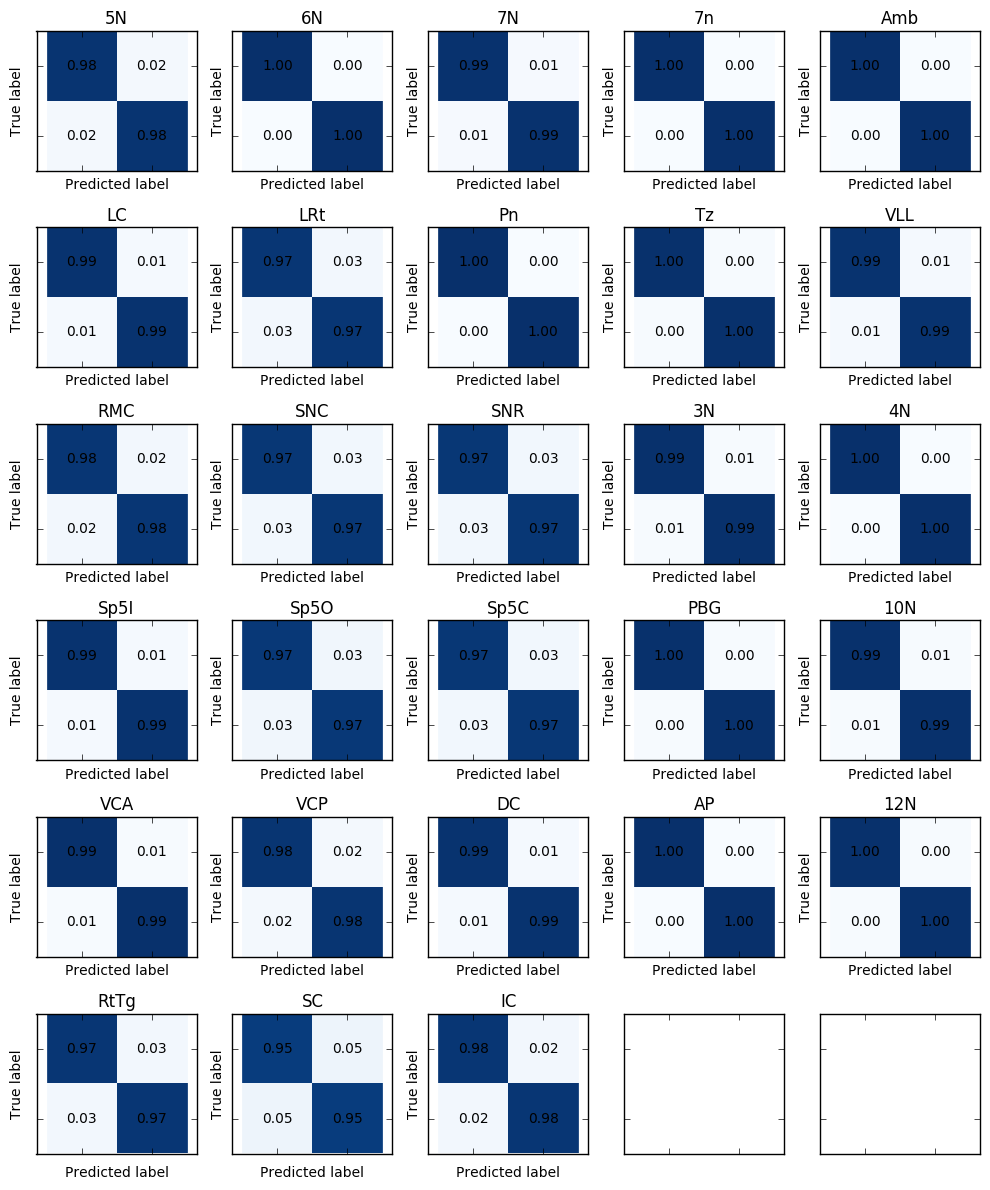

In [148]:
# Compute training accuracy

acc_all_structures = {}

nrows = len(structures)/5 + 1
ncols = 5

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, label in enumerate(structures):
    
    features_pos = training_features[label]
    
    if train_sample_scheme in [1,3,4,5,6,7]:
        features_neg = training_features[convert_to_surround_name(label, 'noclass')]
    elif train_sample_scheme == 2:
        features_neg = np.vstack([training_features[convert_to_surround_name(label, 'noclass')]] + \
                                  [training_features[convert_to_surround_name(label, surr_l)] 
                                  for surr_l in structures if convert_to_surround_name(label, surr_l) in labels])
    else:
        sys.stderr.write('training scheme is not recognized.\n')

    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    svc = svc_allClasses[label]
    
    probs = svc.predict_proba(train_data)[:, svc.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[label] = .5 * (cm[0,0] + cm[1,1])
    
    plot_confusion_matrix(cm, title='%(label)s'% {'label':label},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [149]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.985115947072


# Test

In [24]:
# Extract test samples

test_addresses = defaultdict(list)

for stack in ['MD589', 'MD585', 'MD594']:
    annotation_grid_indices_fn = '/home/yuncong/csd395/CSHL_labelings_v3/%(stack)s/%(stack)s_annotation_grid_indices.h5' % dict(stack=stack)
    label_gridIndices = read_hdf(annotation_grid_indices_fn, 'grid_indices')
    sampled_addresses_sec_idx = sample_locations(label_gridIndices, labels, num_samples_per_landmark=1000)
    
    for name_u, addresses in sampled_addresses_sec_idx.iteritems():
        test_addresses[name_u] += [(stack, ) + addr for addr in addresses]
        
test_addresses.default_factory = None
        
# sampled_addresses = {name_u: np.array(addresses) for name_u, addresses in sampled_addresses.iteritems()}

Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.
Cell is empty.


In [25]:
test_features = apply_function_to_dict(addresses_to_features, test_addresses)

('MD585', 83)
('MD585', 84)
('MD585', 85)
('MD585', 86)
('MD585', 87)
('MD585', 88)
('MD585', 89)
('MD585', 90)
('MD585', 91)
('MD585', 92)
('MD585', 93)
('MD585', 94)
('MD585', 95)
('MD585', 96)
('MD585', 97)
('MD585', 98)
('MD585', 99)
('MD585', 100)
('MD585', 101)
('MD585', 102)
('MD585', 103)
('MD585', 104)
('MD585', 105)
('MD585', 106)
('MD585', 107)
('MD585', 108)
('MD585', 109)
('MD585', 110)
('MD585', 111)
('MD585', 112)
('MD585', 113)
('MD585', 114)
('MD585', 115)
('MD585', 116)
('MD585', 117)
('MD585', 119)
('MD585', 120)
('MD585', 121)
('MD585', 122)
('MD585', 123)
('MD585', 124)
('MD585', 125)
('MD585', 126)
('MD585', 127)
('MD585', 128)
('MD585', 129)
('MD585', 130)
('MD585', 131)
('MD585', 132)
('MD585', 133)
('MD585', 134)
('MD585', 135)
('MD585', 136)
('MD585', 137)
('MD585', 138)
('MD585', 139)


Patch in annotation but not in mask: MD585 139 MD585-N26-2015.08.19-15.37.53_MD585_1_0076 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @53778


('MD585', 140)
('MD585', 141)
('MD585', 142)
('MD585', 143)
('MD585', 144)
('MD585', 145)
('MD585', 146)
('MD585', 147)
('MD585', 148)
('MD585', 149)
('MD585', 150)
('MD585', 151)


Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @55256
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @50597
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @52706
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @50594
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @54826
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @50624
Patch in annotation but not in mask: MD585 151 MD585-N28-2015.08.19-15.47.09_MD585_1_0082 alignedTo 

('MD585', 152)
('MD585', 153)
('MD585', 154)
('MD585', 155)
('MD585', 156)
('MD585', 157)
('MD585', 158)
('MD585', 159)
('MD585', 160)
('MD585', 161)
('MD585', 162)
('MD585', 163)
('MD585', 164)
('MD585', 165)
('MD585', 166)
('MD585', 167)
('MD585', 168)
('MD585', 169)
('MD585', 170)
('MD585', 171)
('MD585', 172)
('MD585', 173)
('MD585', 174)
('MD585', 175)
('MD585', 176)
('MD585', 177)
('MD585', 178)
('MD585', 179)
('MD585', 180)
('MD585', 181)
('MD585', 182)
('MD585', 183)
('MD585', 184)
('MD585', 185)
('MD585', 186)
('MD585', 187)
('MD585', 188)
('MD585', 189)
('MD585', 190)
('MD585', 191)
('MD585', 192)
('MD585', 193)
('MD585', 194)
('MD585', 195)
('MD585', 196)
('MD585', 197)
('MD585', 198)
('MD585', 199)
('MD585', 200)
('MD585', 201)
('MD585', 202)
('MD585', 203)
('MD585', 204)
('MD585', 205)
('MD585', 206)
('MD585', 207)
('MD585', 208)
('MD585', 209)
('MD585', 210)
('MD585', 211)
('MD585', 212)
('MD585', 213)
('MD585', 214)
('MD585', 215)
('MD585', 216)
('MD585', 217)
('MD585', 

Patch in annotation but not in mask: MD585 225 MD585-N40-2015.07.16-22.14.28_MD585_2_0119 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @25552


('MD585', 226)
('MD585', 227)
('MD585', 228)
('MD585', 229)
('MD585', 230)
('MD585', 231)
('MD585', 232)
('MD585', 233)
('MD585', 234)
('MD585', 235)
('MD585', 236)
('MD585', 237)
('MD585', 238)
('MD585', 239)
('MD585', 240)
('MD585', 241)
('MD585', 242)
('MD585', 243)
('MD585', 244)
('MD585', 245)
('MD585', 246)
('MD585', 247)
('MD585', 248)
('MD585', 249)
('MD585', 250)
('MD585', 251)
('MD585', 252)
('MD585', 253)
('MD585', 254)
('MD585', 255)
('MD585', 256)
('MD585', 257)
('MD585', 258)
('MD585', 259)
('MD585', 260)
('MD585', 261)
('MD585', 262)
('MD585', 263)
('MD585', 264)
('MD585', 265)
('MD585', 266)
('MD585', 267)
('MD585', 269)
('MD585', 270)
('MD585', 271)
('MD585', 272)
('MD585', 273)
('MD585', 274)
('MD585', 275)
('MD585', 276)
('MD585', 277)
('MD585', 278)
('MD585', 279)
('MD585', 280)
('MD585', 281)
('MD585', 282)
('MD585', 283)
('MD585', 284)
('MD585', 285)
('MD585', 286)
('MD585', 287)
('MD585', 288)
('MD585', 289)
('MD585', 290)
('MD585', 291)
('MD585', 292)
('MD585', 

Patch in annotation but not in mask: MD585 332 MD585-IHC58-2015.07.16-18.38.08_MD585_1_0172 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @36192
Patch in annotation but not in mask: MD585 332 MD585-IHC58-2015.07.16-18.38.08_MD585_1_0172 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @35981
Patch in annotation but not in mask: MD585 332 MD585-IHC58-2015.07.16-18.38.08_MD585_1_0172 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @34711
Patch in annotation but not in mask: MD585 332 MD585-IHC58-2015.07.16-18.38.08_MD585_1_0172 alignedTo MD585-N47-2015.07.16-22.50.52_MD585_3_0141 @35345


('MD585', 333)
('MD585', 334)
('MD585', 335)
('MD585', 336)
('MD585', 337)
('MD585', 338)
('MD585', 339)
('MD585', 340)
('MD585', 341)
('MD585', 342)
('MD585', 343)
('MD585', 344)
('MD585', 345)
('MD585', 346)
('MD585', 347)
('MD585', 348)
('MD585', 349)
('MD585', 350)
('MD589', 94)
('MD589', 95)
('MD589', 96)
('MD589', 97)
('MD589', 98)
('MD589', 99)
('MD589', 100)
('MD589', 101)
('MD589', 102)
('MD589', 103)
('MD589', 104)
('MD589', 105)
('MD589', 106)
('MD589', 107)
('MD589', 108)
('MD589', 109)
('MD589', 110)
('MD589', 111)
('MD589', 112)
('MD589', 113)
('MD589', 114)
('MD589', 115)
('MD589', 116)
('MD589', 117)
('MD589', 119)
('MD589', 120)
('MD589', 121)
('MD589', 122)
('MD589', 123)
('MD589', 124)
('MD589', 125)
('MD589', 126)
('MD589', 127)
('MD589', 128)
('MD589', 129)
('MD589', 130)
('MD589', 131)
('MD589', 132)
('MD589', 133)
('MD589', 134)
('MD589', 135)
('MD589', 136)
('MD589', 137)
('MD589', 138)
('MD589', 139)
('MD589', 140)
('MD589', 141)
('MD589', 142)
('MD589', 143)
(

Patch in annotation but not in mask: MD594 139 MD594-N27-2015.08.26-22.22.46_MD594_1_0079 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @47322


('MD594', 140)
('MD594', 141)
('MD594', 142)
('MD594', 143)
('MD594', 144)
('MD594', 145)
('MD594', 146)
('MD594', 147)
('MD594', 148)
('MD594', 149)
('MD594', 150)
('MD594', 151)
('MD594', 152)
('MD594', 153)
('MD594', 154)
('MD594', 155)
('MD594', 156)
('MD594', 157)
('MD594', 158)
('MD594', 159)
('MD594', 160)
('MD594', 161)
('MD594', 162)
('MD594', 163)
('MD594', 164)
('MD594', 165)
('MD594', 166)
('MD594', 167)
('MD594', 168)
('MD594', 169)
('MD594', 170)
('MD594', 171)
('MD594', 172)
('MD594', 173)
('MD594', 174)
('MD594', 175)
('MD594', 176)
('MD594', 177)
('MD594', 178)
('MD594', 179)
('MD594', 180)
('MD594', 181)
('MD594', 182)
('MD594', 183)
('MD594', 184)
('MD594', 185)
('MD594', 186)
('MD594', 188)
('MD594', 189)
('MD594', 190)
('MD594', 191)
('MD594', 192)
('MD594', 194)
('MD594', 195)
('MD594', 196)
('MD594', 197)
('MD594', 198)
('MD594', 199)
('MD594', 200)
('MD594', 201)
('MD594', 202)
('MD594', 203)
('MD594', 204)
('MD594', 205)
('MD594', 206)
('MD594', 207)
('MD594', 

Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @44235
Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @44038
Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @45604
Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @45797
Patch in annotation but not in mask: MD594 273 MD594-N61-2015.08.27-00.31.50_MD594_1_0181 alignedTo MD594-IHC58-2015.08.26-18.48.50_MD594_1_0172 @44626


('MD594', 274)
('MD594', 275)
('MD594', 276)
('MD594', 277)
('MD594', 278)
('MD594', 279)
('MD594', 280)
('MD594', 281)
('MD594', 282)
('MD594', 283)
('MD594', 284)
('MD594', 285)
('MD594', 286)
('MD594', 287)
('MD594', 288)
('MD594', 289)
('MD594', 290)
('MD594', 291)
('MD594', 292)
('MD594', 293)
('MD594', 294)
('MD594', 295)
('MD594', 296)
('MD594', 297)
('MD594', 298)
('MD594', 299)
('MD594', 300)
('MD594', 301)
('MD594', 302)
('MD594', 303)
('MD594', 304)
('MD594', 305)
('MD594', 306)
('MD594', 307)
('MD594', 308)
('MD594', 309)
('MD594', 310)
('MD594', 311)
('MD594', 312)
('MD594', 313)
('MD594', 314)
('MD594', 315)
('MD594', 316)
('MD594', 317)
('MD594', 318)
('MD594', 319)
('MD594', 320)
('MD594', 321)
('MD594', 322)
('MD594', 323)
('MD594', 324)
('MD594', 325)
('MD594', 326)
('MD594', 327)
('MD594', 328)
('MD594', 329)
('MD594', 330)
('MD594', 331)
('MD594', 332)
('MD594', 333)
('MD594', 334)
('MD594', 335)
('MD594', 336)
('MD594', 337)
('MD594', 338)
('MD594', 339)
('MD594', 

In [26]:
test_features = {name: np.array([f for f in feats if f is not None]) for name, feats in test_features.iteritems()}

In [38]:
# Save test features

test_feat_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR, 'test_features'))

for name_u, feats in test_features.iteritems():
    bp.pack_ndarray_file(feats, os.path.join(test_feat_dir, name_u + '.bp'))

In [ ]:
# Load test features

test_feat_dir = create_if_not_exists(os.path.join(SVM_ROOTDIR, 'test_features'))

test_features = {name_u: bp.unpack_ndarray_file(os.path.join(test_feat_dir, name_u + '.bp'))
                     for name_u in labels_to_sample}

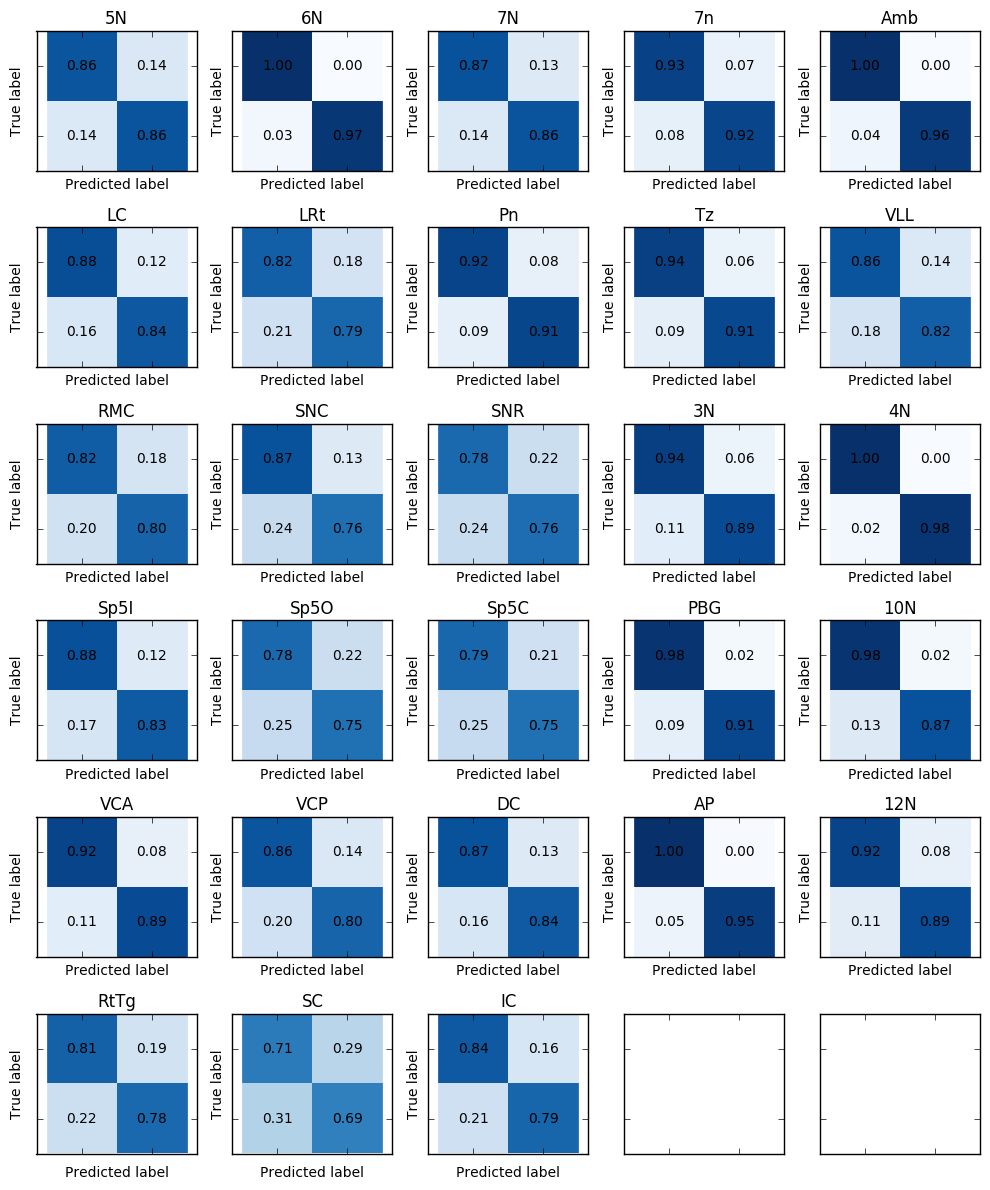

In [150]:
# Compute test accuracy

acc_all_structures = {}

nrows = len(structures)/5 + 1
ncols = 5

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, label in enumerate(structures):
    
    features_pos = test_features[label]
    
#     features_neg = test_features[convert_to_surround_name(label)]
    
    if train_sample_scheme in [1,3,4,5,6,7]:
        features_neg = test_features[convert_to_surround_name(label, 'noclass')]
    elif train_sample_scheme == 2:
        features_neg = np.vstack([test_features[convert_to_surround_name(label, 'noclass')]] + \
                                  [test_features[convert_to_surround_name(label, surr_l)] 
                                  for surr_l in structures if convert_to_surround_name(label, surr_l) in labels])
    else:
        sys.stderr.write('training scheme is not recognized.\n')
        
    
    test_data = np.r_[features_pos, features_neg]
    test_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    svc = svc_allClasses[label]
    
    probs = svc.predict_proba(test_data)[:, svc.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in test_labels], soft=True)
    
    acc_all_structures[label] = .5 * (cm[0,0] + cm[1,1])
    
    plot_confusion_matrix(cm, title='%(label)s'% {'label':label},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [151]:
print 'test accuracy:', np.mean(acc_all_structures.values())

test accuracy: 0.868003951425


In [ ]:
# Predict full frame

In [ ]:
stack = 'MD591'

filenames_to_sections, sections_to_filenames = DataManager.load_sorted_filenames(stack)
first_sec, last_sec = DataManager.load_cropbox(stack)[4:]
anchor_fn = DataManager.load_anchor_filename(stack)

In [ ]:
def svm_predict(stack, sec):
    fn = sections_to_filenames[sec]
    if fn in ['Nonexisting', 'Rescan', 'Placeholder']:
        return

    feature_fn = PATCH_FEATURES_ROOTDIR + '/%(stack)s/%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped/%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped_features.hdf' % dict(stack=stack, fn=fn, anchor_fn=anchor_fn)
    
    try:
        features = load_hdf(feature_fn)
    except Exception as e:
        sys.stderr.write(e.message + '\n')
        return
    
    output_dir = create_if_not_exists(os.path.join(SPARSE_SCORES_ROOTDIR, stack, '%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped' % \
                                      {'fn': fn, 'anchor_fn': anchor_fn}))
    
    for label in structures:
        svc = svc_allClasses[label]
        probs = svc.predict_proba(features)[:, svc.classes_.tolist().index(1.)]
        output_fn = output_dir + '/%(fn)s_lossless_alignedTo_%(anchor_fn)s_cropped_%(label)s_sparseScores.hdf' % \
                    {'fn': fn, 'anchor_fn': anchor_fn, 'label':label}
        bp.pack_ndarray_file(probs, output_fn)

In [ ]:
t = time.time()
# Parallel(n_jobs=8)(delayed(svm_predict)(stack=stack, sec=sec) for sec in range(first_sec, last_sec+1))
Parallel(n_jobs=8)(delayed(svm_predict)(stack=stack, sec=sec) for sec in range(200, 201))
sys.stderr.write('svm predict: %.2f seconds\n' % (time.time() - t)) # 35 s / 10 section; 863 seconds /stack